In [50]:
import gc
import os

import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from glob import glob

In [3]:
dtypes = {
    'ip': 'uint32',
    'app': 'uint16',
    'device': 'uint16',
    'os': 'uint16',
    'channel': 'uint16',
    'is_attributed': 'uint8'
}

In [5]:
sorted(glob('../data/interim/train_2017-*_features.csv'))

['../data/interim/train_2017-11-08_1000_features.csv']

In [22]:
df_train = pd.read_csv('../data/interim/train_2017-11-08_1000_features.csv', dtype=dtypes)

In [23]:
df_train.columns

Index(['app', 'device', 'os', 'channel', 'click_time', 'is_attributed',
       'COUNT(clicks)_channel_1hour',
       'PERCENT_TRUE(clicks.is_attributed)_channel_1hour',
       'NUM_UNIQUE(clicks.app)_channel_1hour',
       'NUM_UNIQUE(clicks.device)_channel_1hour',
       ...
       'NUM_UNIQUE(clicks.os.MODE(clicks.channel))_channel_1hour',
       'MODE(clicks.app.MODE(clicks.device))_channel_1hour',
       'MODE(clicks.app.MODE(clicks.os))_channel_1hour',
       'MODE(clicks.app.MODE(clicks.channel))_channel_1hour',
       'MODE(clicks.device.MODE(clicks.app))_channel_1hour',
       'MODE(clicks.device.MODE(clicks.os))_channel_1hour',
       'MODE(clicks.device.MODE(clicks.channel))_channel_1hour',
       'MODE(clicks.os.MODE(clicks.app))_channel_1hour',
       'MODE(clicks.os.MODE(clicks.device))_channel_1hour',
       'MODE(clicks.os.MODE(clicks.channel))_channel_1hour'],
      dtype='object', length=130)

In [24]:
df_train.drop(columns=['click_time'], inplace=True)

In [25]:
X = df_train.copy()
y = X.pop('is_attributed')

In [57]:
params = {
    'eta': 0.3,
    'tree_method': "hist",
    'grow_policy': "lossguide",
    'max_leaves': 1400,  
    'max_depth': 0, 
    'subsample': 0.9, 
    'colsample_bytree': 0.7, 
    'colsample_bylevel':0.7,
    'min_child_weight':0,
    'alpha':4,
    'objective': 'binary:logistic', 
    'scale_pos_weight':100,
    'eval_metric': 'auc', 
    'nthread':8,
    'random_state': 99, 
    'silent': True
}

In [58]:
test_size = 3000000
x1, x2, y1, y2 = X.iloc[:test_size], X.iloc[test_size:], y.iloc[:test_size], y.iloc[test_size:]

dtrain = xgb.DMatrix(x1, y1)
dvalid = xgb.DMatrix(x2, y2)
del x1, y1, x2, y2 
gc.collect()
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
model = xgb.train(params, dtrain, 200, watchlist, maximize=True, early_stopping_rounds=25, verbose_eval=1)
del dvalid

[0]	train-auc:0.96627	valid-auc:0.946433
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 25 rounds.
[1]	train-auc:0.97477	valid-auc:0.954433
[2]	train-auc:0.974447	valid-auc:0.959153
[3]	train-auc:0.972401	valid-auc:0.959005
[4]	train-auc:0.970906	valid-auc:0.958462
[5]	train-auc:0.974573	valid-auc:0.957417
[6]	train-auc:0.974868	valid-auc:0.958954
[7]	train-auc:0.973559	valid-auc:0.958927
[8]	train-auc:0.978655	valid-auc:0.959407
[9]	train-auc:0.97778	valid-auc:0.959378
[10]	train-auc:0.979312	valid-auc:0.958075
[11]	train-auc:0.981183	valid-auc:0.958378
[12]	train-auc:0.98146	valid-auc:0.957363
[13]	train-auc:0.981698	valid-auc:0.958304
[14]	train-auc:0.982701	valid-auc:0.957797
[15]	train-auc:0.982761	valid-auc:0.958025
[16]	train-auc:0.983004	valid-auc:0.957472
[17]	train-auc:0.983078	valid-auc:0.956818
[18]	train-auc:0.983512	valid-auc:0.956407
[19]	train-auc:0.983546	valid-auc:0.956105
[20]	train-

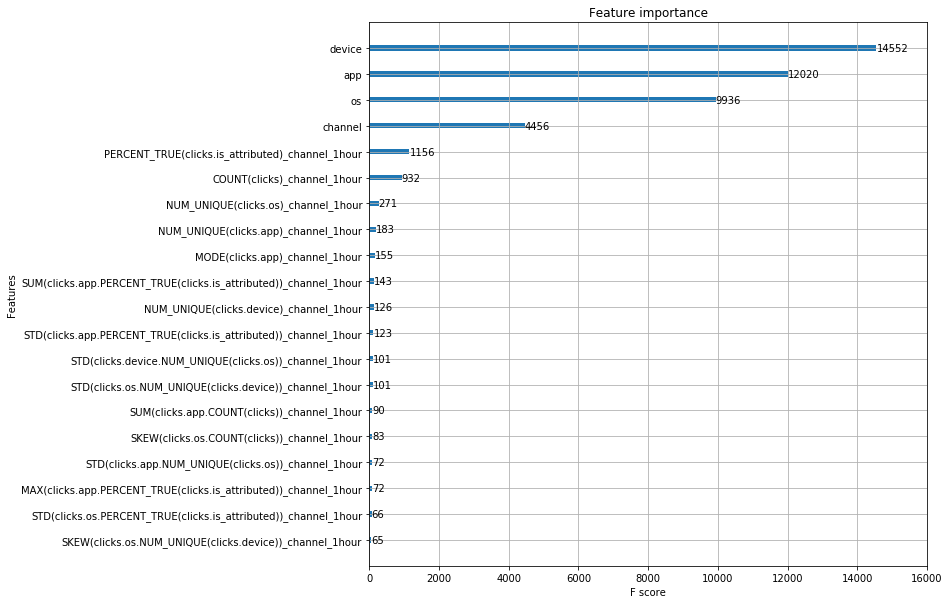

In [59]:
fig, ax = plt.subplots(figsize=(10, 10))
xgb.plot_importance(model, ax=ax, max_num_features=20)